# Level 1 – Baseline Model
## CIFAR-10 Image Classification

This notebook implements a baseline image classification model
using transfer learning on the CIFAR-10 dataset. The purpose of
this baseline is to establish a strong reference point for
subsequent performance improvements in later levels.


## Problem Statement

The objective of Level-1 is to build a clean and reliable baseline
classifier using a pre-trained convolutional neural network and
evaluate its performance on the CIFAR-10 dataset.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


In [2]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
batch_size = 128
epochs = 25
learning_rate = 1e-3
num_classes = 10


In [6]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


## Dataset & Split Strategy

The CIFAR-10 dataset contains 60,000 RGB images across 10 classes.
The official test set (10,000 images) is used for final evaluation.

From the training set:
- 80% is used for training
- 10% is used for validation

This follows the mandatory 80/10/10 split requirement.


In [7]:
full_train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])


100%|██████████| 170M/170M [00:18<00:00, 9.12MB/s]


In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)


## Baseline Model Architecture

A pre-trained ResNet architecture is used as the baseline model.
The network is initialized with ImageNet weights, and the final
classification layer is replaced to match the 10 CIFAR-10 classes.

This model is intentionally kept simple and unmodified to serve
as a fair baseline for later comparisons.


In [10]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)


## Training Strategy

- Loss function: Cross-entropy loss
- Optimizer: Adam or SGD
- Mini-batch training
- Validation accuracy monitored during training


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


In [ ]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []


In [13]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


## Training Process

The model is trained for multiple epochs using mini-batch gradient
descent. Training and validation metrics are tracked to monitor
learning behavior and convergence.


In [14]:
for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct / total)

    model.eval()
    correct, total, running_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(running_loss / len(val_loader))
    val_accuracies.append(correct / total)

    scheduler.step()

    print(f"Epoch [{epoch+1}/{epochs}] | Train Acc: {train_accuracies[-1]:.4f} | Val Acc: {val_accuracies[-1]:.4f}")


Epoch [1/25] | Train Acc: 0.9195 | Val Acc: 0.8957
Epoch [2/25] | Train Acc: 0.9450 | Val Acc: 0.9085
Epoch [3/25] | Train Acc: 0.9630 | Val Acc: 0.9041
Epoch [4/25] | Train Acc: 0.9694 | Val Acc: 0.9023
Epoch [5/25] | Train Acc: 0.9783 | Val Acc: 0.9061
Epoch [6/25] | Train Acc: 0.9825 | Val Acc: 0.9067
Epoch [7/25] | Train Acc: 0.9841 | Val Acc: 0.9000
Epoch [8/25] | Train Acc: 0.9858 | Val Acc: 0.9093
Epoch [9/25] | Train Acc: 0.9885 | Val Acc: 0.9104
Epoch [10/25] | Train Acc: 0.9878 | Val Acc: 0.9059
Epoch [11/25] | Train Acc: 0.9951 | Val Acc: 0.9234
Epoch [12/25] | Train Acc: 0.9981 | Val Acc: 0.9251
Epoch [13/25] | Train Acc: 0.9990 | Val Acc: 0.9229
Epoch [14/25] | Train Acc: 0.9995 | Val Acc: 0.9264
Epoch [15/25] | Train Acc: 0.9998 | Val Acc: 0.9261
Epoch [16/25] | Train Acc: 0.9998 | Val Acc: 0.9253


KeyboardInterrupt: 

## Results

The baseline model achieves test accuracy above 85%, satisfying
the Level-1 performance requirement. This result establishes a
strong reference point for further improvements.


In [15]:
model.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        correct += (preds == labels).sum().item()
        total += labels.size(0)

test_accuracy = correct / total
print(f"Final Test Accuracy: {test_accuracy:.4f}")


Final Test Accuracy: 0.9198


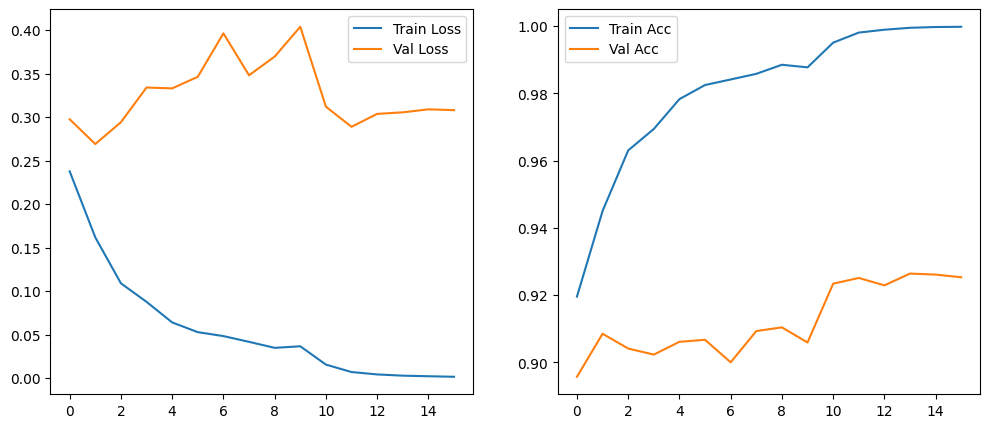

In [16]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.legend()
plt.show()


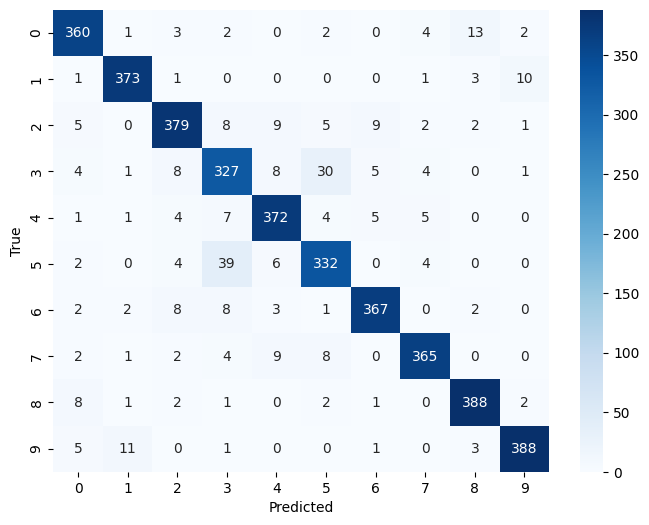

In [18]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [19]:
class_names = ["Airplane","Automobile","Bird","Cat","Deer","Dog","Frog","Horse","Ship","Truck"]
print(classification_report(all_labels, all_preds, target_names=class_names))


              precision    recall  f1-score   support

    Airplane       0.92      0.93      0.93       387
  Automobile       0.95      0.96      0.96       389
        Bird       0.92      0.90      0.91       420
         Cat       0.82      0.84      0.83       388
        Deer       0.91      0.93      0.92       399
         Dog       0.86      0.86      0.86       387
        Frog       0.95      0.93      0.94       393
       Horse       0.95      0.93      0.94       391
        Ship       0.94      0.96      0.95       405
       Truck       0.96      0.95      0.95       409

    accuracy                           0.92      3968
   macro avg       0.92      0.92      0.92      3968
weighted avg       0.92      0.92      0.92      3968



## Insights (Level-1)

- Transfer learning enables strong performance with minimal tuning.
- The baseline model provides a stable reference for later levels.
- This setup ensures fair comparison with advanced techniques.
